## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [1]:
import pandas as pd
import psycopg2
from psycopg2 import Error
import requests as re
from scipy import stats
from matplotlib import pyplot
import numpy as np
import datetime
from collections import Counter, OrderedDict
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [255]:
connection = psycopg2.connect(user="lhl_student",
                                  password="lhl_student",
                                  host="lhl-data-bootcamp.crzjul5qln0e.ca-central-1.rds.amazonaws.com",
                                  port="5432",
                                  database="mid_term_project")
cursor=connection.cursor()

In [129]:
#what columns are in the flights dataset
flights_columns = "select * from flights limit 10"
cursor.execute(flights_columns)
flights_columns = pd.read_sql_query(flights_columns,connection)

In [130]:
flights_columns.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name'],
      dtype='object')

In [126]:
#columns in passengers
passengers_columns = "select * from passengers limit 10"
cursor.execute(passengers_columns)
passengers_columns = pd.read_sql_query(passengers_columns,connection)

In [128]:
passengers_columns.columns

Index(['departures_scheduled', 'departures_performed', 'payload', 'seats',
       'passengers', 'freight', 'mail', 'distance', 'ramp_to_ramp', 'air_time',
       'unique_carrier', 'airline_id', 'unique_carrier_name', 'region',
       'carrier', 'carrier_name', 'carrier_group', 'carrier_group_new',
       'origin_airport_id', 'origin_city_market_id', 'origin',
       'origin_city_name', 'origin_country', 'origin_country_name',
       'dest_airport_id', 'dest_city_market_id', 'dest', 'dest_city_name',
       'dest_country', 'dest_country_name', 'aircraft_group', 'aircraft_type',
       'aircraft_config', 'year', 'month', 'distance_group', 'class',
       'data_source'],
      dtype='object')

In [131]:
#columns in fuel_comsumption
fuel_comsumption_columns = "select * from fuel_comsumption limit 10"
cursor.execute(fuel_comsumption_columns)
fuel_comsumption_columns = pd.read_sql_query(fuel_comsumption_columns,connection)

In [132]:
fuel_comsumption_columns.columns

Index(['month', 'airline_id', 'unique_carrier', 'carrier', 'carrier_name',
       'carrier_group_new', 'sdomt_gallons', 'satl_gallons', 'spac_gallons',
       'slat_gallons', 'sint_gallons', 'ts_gallons', 'tdomt_gallons',
       'tint_gallons', 'total_gallons', 'sdomt_cost', 'satl_cost', 'spac_cost',
       'slat_cost', 'sint_cost', 'ts_cost', 'tdomt_cost', 'tint_cost',
       'total_cost', 'year'],
      dtype='object')

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [60]:
dly = 'select arr_delay from flights'
cursor.execute(dly)

In [125]:
dlay = pd.read_sql_query(dly,connection)

In [75]:
dlay = dlay.fillna(value=0.0)

(array([1.0000000e+00, 1.0000000e+00, 5.3588930e+06, 1.0230152e+07,
        1.9415000e+04, 6.5060000e+03, 7.1100000e+02, 5.0000000e+01,
        5.0000000e+00, 7.0000000e+00]),
 array([-1290. ,  -863.7,  -437.4,   -11.1,   415.2,   841.5,  1267.8,
         1694.1,  2120.4,  2546.7,  2973. ]),
 <BarContainer object of 10 artists>)

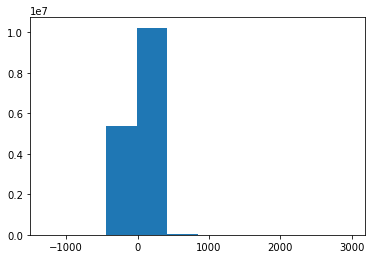

In [62]:
#histogram after filling nan values (at this point nan means 0) but before outlier detection
pyplot.hist(dlay)

In [76]:
dlay.mean()

arr_delay    5.368754
dtype: float64

In [77]:
dlay.max()

arr_delay    2973.0
dtype: float64

In [78]:
dlay.min()

arr_delay   -1290.0
dtype: float64

In [79]:
#outlier detection
for x in dlay:
    q75,q25 = np.percentile(dlay,[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    dlay.loc[dlay[x] < min,x] = np.nan
    dlay.loc[dlay[x] > max,x] = np.nan

In [80]:
dlay.max()

arr_delay    40.0
dtype: float64

In [81]:
dlay.min()

arr_delay   -48.0
dtype: float64

(array([  64896.,  317296., 1266329., 3236013., 3550695., 2970889.,
        1387085.,  780087.,  492937.,  340585.]),
 array([-48. , -39.2, -30.4, -21.6, -12.8,  -4. ,   4.8,  13.6,  22.4,
         31.2,  40. ]),
 <BarContainer object of 10 artists>)

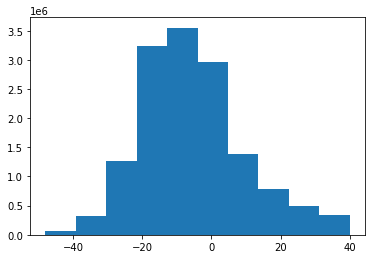

In [82]:
#not filling nan in because now those are outliers, not zeros
pyplot.hist(dlay)

In [83]:
dlay.mean()

arr_delay   -5.530624
dtype: float64

In [52]:
#mean isnt zero, but with outlier detection it looks to be close to a normal distribution

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [84]:
date_dly = 'select fl_date, arr_delay from flights'
cursor.execute(date_dly)

In [126]:
date_dlay = pd.read_sql_query(date_dly,connection)

In [98]:
date_dlay.dtypes

fl_date      datetime64[ns]
arr_delay           float64
dtype: object

In [102]:
date_dlay['fl_date']= pd.to_datetime(date_dlay['fl_date'])

In [115]:
#filling the nan in arrivals delay
date_dlay = date_dlay.fillna(value=0.0)

In [118]:
date_dlay.groupby(date_dlay['fl_date'].dt.month).mean()

,arr_delay
fl_date,
1,3.887832
2,6.552948
3,2.744758
4,4.076403
5,6.382056
6,10.170076
7,8.770911
8,8.699921
9,1.677649


In [127]:
#june largest average delay, could be due to vacation season? all the 3 summer months off primary school are high, winter picks up a bit too (maybe due to weather in winter)

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [ ]:
#tried numerous different times, even selecting specifically winter months to pull weather information from but could not get any results with snow

In [3]:
datasets = ['apr.csv','aug.csv','dec.csv','feb.csv','jan.csv','july.csv','june.csv','mar.csv','may.csv','nov.csv','oct.csv','sep.csv']
names = ['apr','aug','dec','feb','jan','july','june','mar','may','nov','octo','sep']

In [4]:
i = 0
for ele in datasets:
    vars()[names[i]] = pd.read_csv("C:/Users/zain_/LHL/Midterm/mid-term-project-I/datasets per month/"+ele)
    i+=1

In [5]:
fulldf =  pd.concat([apr,aug,dec,feb,jan,july,june,mar,may,nov,octo,sep], ignore_index=True)

In [8]:
#saving df for later use as well
fulldf.to_csv('fulldf.csv',index=False)

In [9]:
#dataset with 10,000 rows per month as it was taking an extremely long time for me to pull this amount from the database myself

In [381]:
fulldf_sample = fulldf.sample(frac=1)

In [431]:
weather_sample = fulldf[fulldf['fl_date']=='2019-11-01']

In [432]:
weather_sample=weather_sample.reset_index()

In [433]:
weather_sample = weather_sample.drop('index',axis=1)

In [435]:
weather_sub = weather_sample[0:1000]

In [383]:
weather_sample = weather_sample.reset_index()
weather_sample = weather_sample.drop('index',axis=1)

In [436]:
city_names = weather_sub['origin_city_name']
flight_date = weather_sub['fl_date']

In [399]:
weather_key = os.environ["WETH_API"]

In [438]:
jsonlist = []
i=0
for ele in city_names:
    url = 'http://api.weatherapi.com/v1/current.json'
    params = {'key': weather_key, 'q':ele, 'dt':flight_date[i]}
    response = re.get(url, params = params)
    i+=1
    b = response.json()
    jsonlist.append(b)
conditions = []
for ele in jsonlist:
    conditions.append(ele['current']['condition']['text'])
weather_sub['weather_status'] = conditions

In [439]:
#showing amount and all kinds of weather in the dataset
Counter(weather_sub['weather_status'])

Counter({'Sunny': 289,
         'Partly cloudy': 579,
         'Overcast': 118,
         'Moderate or heavy rain with thunder': 3,
         'Patchy light rain with thunder': 3,
         'Light rain': 8})

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

In [15]:
taxi_amount_in = "select fl_date, dep_time, COUNT(dep_time) as flights_leaving, SUM(taxi_out) from flights group by fl_date, dep_time"
cursor.execute(taxi_amount_in)

In [16]:
taxi_in = pd.read_sql_query(taxi_amount_in,connection)

In [68]:
taxi_in

,fl_date,dep_time,flights_leaving,sum
0,2018-01-01,1.0,5,88.0
1,2018-01-01,2.0,1,17.0
2,2018-01-01,3.0,1,26.0
3,2018-01-01,4.0,3,29.0
4,2018-01-01,5.0,3,59.0
...,...,...,...,...
902577,2019-12-31,2357.0,3,40.0
902578,2019-12-31,2358.0,5,119.0
902579,2019-12-31,2359.0,2,21.0
902580,2019-12-31,2400.0,1,36.0


In [69]:
taxi_times = taxi_in['dep_time']

In [76]:
taxi_times = pd.DataFrame(taxi_times)

In [75]:
taxi_times['sum'] = taxi_in['sum']

In [80]:
taxi_times = taxi_times.dropna()

In [81]:
taxi_times

,dep_time,sum
0,1.0,88.0
1,2.0,17.0
2,3.0,26.0
3,4.0,29.0
4,5.0,59.0
...,...,...
902576,2356.0,11.0
902577,2357.0,40.0
902578,2358.0,119.0
902579,2359.0,21.0


In [93]:
taxi_times = taxi_times.groupby(['dep_time']).sum()

In [101]:
taxi_times = taxi_times.reset_index()

In [102]:
taxi_times

,dep_time,sum
0,1.0,29797.0
1,2.0,24181.0
2,3.0,24606.0
3,4.0,22507.0
4,5.0,21317.0
...,...,...
1435,2356.0,36740.0
1436,2357.0,35850.0
1437,2358.0,32547.0
1438,2359.0,32161.0


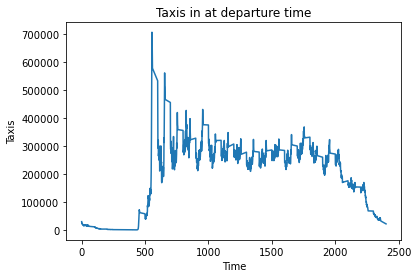

In [103]:
#amount of taxis peaks around 6 am, constant for most of the rest of the day with slight peaks
plt.plot(taxi_times['dep_time'],taxi_times['sum'])
plt.title('Taxis in at departure time')
plt.xlabel('Time')
plt.ylabel('Taxis')
plt.show()

In [107]:
taxi_traffic = taxi_in['flights_leaving']

In [108]:
taxi_traffic = pd.DataFrame(taxi_traffic)

In [110]:
taxi_traffic['sum'] = taxi_in['sum']

In [115]:
taxi_traffic = taxi_traffic.dropna()

In [119]:
taxi_traffic = taxi_traffic.groupby(['flights_leaving']).mean()

In [123]:
taxi_traffic = taxi_traffic.reset_index()

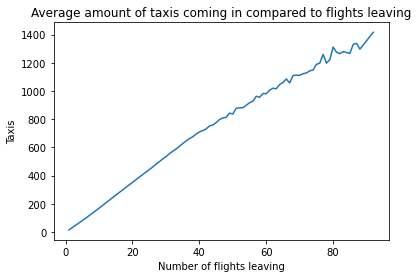

In [124]:
#as more flights are leaving, amount of taxis coming in increases
plt.plot(taxi_traffic['flights_leaving'],taxi_traffic['sum'])
plt.title('Average amount of taxis coming in compared to flights leaving')
plt.xlabel('Number of flights leaving')
plt.ylabel('Taxis')
plt.show()

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

In [162]:
both_delays = "select dep_delay, arr_delay from flights"
cursor.execute(both_delays)

In [185]:
both_delays = pd.read_sql_query(both_delays,connection)

In [195]:
both_delays = both_delays.dropna()

In [209]:
#late departures only
late_dep = both_delays[both_delays['dep_delay']>0]

In [224]:
#late departures that had a late arrival
len(late_dep[late_dep['arr_delay']>0])

3900977

In [222]:
#all late arrival flights
late_arr=both_delays[both_delays['arr_delay']>0]

In [223]:
len(late_arr)

5474411

In [216]:
#out of all late arrivals, this percentage had late departures
3900977/5474411

0.7125838743199954

In [225]:
#can see how many flights had an arrival delay smaller than their departure delay, meaning they made up time during the flight
arr_lower_dep = both_delays[both_delays['dep_delay']>both_delays['arr_delay']]

In [226]:
len(arr_lower_dep)

11089042

In [232]:
len(both_delays)

15611152

In [233]:
#percentage of time the airline was able to make up time during the flight
11089042/15611152

0.7103282320228513

#### **Task 6**: How many states cover 50% of US air traffic? 

In [236]:
citynames = "select origin_city_name from flights"
cursor.execute(citynames)

In [237]:
citynames = pd.read_sql_query(citynames,connection)

In [247]:
citynames['state']=citynames['origin_city_name'].str.split(',').str[1]

In [249]:
citynames = citynames.drop('origin_city_name',axis=1)

In [260]:
len(citynames)

15927485

In [261]:
#50% of the traffic must be around this number
15927485/2

7963742.5

In [256]:
#isolated just state for each flight in the dataframe, now count
counted_states = Counter(citynames['state'])

In [274]:
counted_states_ordered = dict(counted_states.most_common())

In [277]:
state_values = counted_states_ordered.values()

In [296]:
#8 states cover over 50% of US traffic
i = 0
c = 0
thresh = 7963742.5
for ele in state_values:
    if c < thresh:
        c += ele
        i+=1
    else:
        break
print(i)
print(c)

8
8497155


In [306]:
states = []
for ele in counted_states_ordered.keys():
    states.append(ele)

In [308]:
#these 8 states cover over 50% of US air traffic
states[0:7]

[' CA', ' TX', ' FL', ' IL', ' GA', ' NY', ' NC']

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

In [319]:
#use both_delays table from earlier, test if when departure delay is > 0, arrival delay decreases more than it would if there was a departure delay=<0
not_late_dep = both_delays[both_delays['dep_delay']<=0]

In [324]:
dep_mean_nl = not_late_dep['dep_delay'].mean()

In [325]:
arr_mean_nl = not_late_dep['arr_delay'].mean()

In [335]:
#on flights that dont leave late, this is the amount of time faster they arrive than expected
dep_mean_nl - arr_mean_nl

5.196420497519841

In [320]:
late_dep = both_delays[both_delays['dep_delay']>0]

In [329]:
dep_mean_l=late_dep['dep_delay'].mean()

In [330]:
arr_mean_l = late_dep['arr_delay'].mean()

In [336]:
#on flights that leave late, this is the amount of time faster they arrive than expected
dep_mean_l - arr_mean_l

4.612597572861837

In [ ]:
#it seems like they arrive less early when theres a departure delay, meaning they dont fly faster

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

In [11]:
#short haul is 3 hours or less, medium is 3-6 hours, long is 6+
haul = "select dep_time, air_time from flights"
cursor.execute(haul)
haul = pd.read_sql_query(haul,connection)

In [12]:
hour_dep_time = []
for ele in haul['dep_time']:
    ele = str(ele)
    ele = ele[:-4]
    if ele == '':
        ele ='0'
    hour_dep_time.append(ele)

In [13]:
haul['dep_time'] = hour_dep_time

In [14]:
hours = set(haul['dep_time'])

In [25]:
#drop nulls
haul = haul.dropna()

In [26]:
#defining all the flights
flighttypelist = []
for ele in haul['air_time']:
    if ele <= 180.0:
        flighttypelist.append('SHORT')
    if 180.0 < ele <= 360.0:
        flighttypelist.append('MEDIUM')
    if ele > 360.0:
        flighttypelist.append('LONG')

In [27]:
haul['haul_type']=flighttypelist

In [39]:
#function to find hour with most of each type
def sort_hauls(haultype):
    htype = haul[haul['haul_type']==haultype]
    x = Counter(htype['dep_time'])
    return x.most_common()[0]

In [40]:
#6:00 has the most short haul
sort_hauls('SHORT')

('6', 850116)

In [41]:
#8:00 has the most medium haul
sort_hauls('MEDIUM')

('8', 151565)

In [42]:
#11:00 has the most long hauls
sort_hauls('LONG')

('11', 6070)

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

In [58]:
#origin is the airport name
airport_busy = "select fl_date, origin from flights"
cursor.execute(airport_busy)
airport_busy = pd.read_sql_query(airport_busy,connection)

In [99]:
airport_busy

,fl_date,origin
0,2019-01-01,ATL
1,2019-01-01,LGA
2,2019-01-01,LAX
3,2019-01-01,RSW
4,2019-01-01,AUS
...,...,...
15927480,2019-01-01,CVG
15927481,2019-01-01,MCO
15927482,2019-01-01,LGA
15927483,2019-01-01,BZN


In [60]:
airportcount=Counter(airport_busy['origin'])

In [63]:
#10 most common airports
airportcount.most_common()[0:10]

[('ORD', 790253),
 ('ATL', 785850),
 ('DFW', 584688),
 ('DEN', 552134),
 ('CLT', 501557),
 ('LAX', 500840),
 ('SEA', 379367),
 ('SFO', 357626),
 ('PHX', 355485),
 ('IAH', 354379)]

In [115]:
ten_top_ports = airportcount.most_common()[0:10]

In [120]:
tentotal = 0
for ele in ten_top_ports:
    e = int(ele[1])
    tentotal +=e

In [122]:
totalamount = len(airport_busy)

In [124]:
#the top 10 airports cover this percentage of traffic going out
tentotal/totalamount

0.32410509254913755

In [80]:
#range of dates needed from passengers
uniqdates = set(airport_busy['fl_date'])
#most recent date is 2018-01-01, last is 2019-12-31

In [89]:
passengers_busy = "select origin, SUM(passengers) from passengers where year = 2018 OR year = 2019 group by origin"
cursor.execute(passengers_busy)
passengers_busy = pd.read_sql_query(passengers_busy,connection)

In [94]:
passengers_busy.sort_values('sum', ascending=False).head(10)

,origin,sum
135,ATL,106124756.0
1007,LAX,86663992.0
1375,ORD,81047662.0
462,DFW,68792565.0
460,DEN,65570991.0
886,JFK,61883777.0
1648,SFO,55930960.0
1637,SEA,49076280.0
1005,LAS,48841318.0
1117,MCO,48136663.0


In [ ]:
#the airports that have the most flights going out are mostly the ones that have the most passengers going through them as well during that time frame, with a few exceptions

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

In [154]:
delay_dates = "select fl_date, mkt_carrier, SUM(dep_delay) as dep_delay, SUM(distance) as distance from flights group by mkt_carrier, fl_date"
cursor.execute(delay_dates)
delay_dates = pd.read_sql_query(delay_dates,connection)

In [165]:
delay_dates.isnull().sum()

fl_date        0
mkt_carrier    0
dep_delay      0
distance       0
dtype: int64

In [166]:
#convert to datetime so can seperate for month
delay_dates['fl_date'] = pd.to_datetime(delay_dates['fl_date'])

In [191]:
carriernames = set(delay_dates['mkt_carrier'])
carriernames = list(carriernames)

In [313]:
carriernames

['WN', 'AA', 'HA', 'G4', 'VX', 'UA', 'B6', 'AS', 'F9', 'DL', 'NK']

In [266]:
#dictionary that holds all the dataframes created for each carrier i need
flights_carrier_dict = {}
for name in carriernames:
    flights_carrier_dict[name] = delay_dates[delay_dates['mkt_carrier']==name]

In [269]:
#dictionary for the right formatted dataframes
carrier_flights = {}
for ele in carriernames:
    carrier_flights[ele] = flights_carrier_dict[ele].groupby([(flights_carrier_dict[ele].fl_date.dt.year), (flights_carrier_dict[ele].fl_date.dt.month)]).sum()
    carrier_flights[ele]

In [232]:
#getting passengers data
passengers_dates = "select passengers, carrier, year, month from passengers where year = 2018 or year = 2019"
cursor.execute(passengers_dates)
passengers_dates = pd.read_sql_query(passengers_dates,connection)

In [240]:
#dictionary that holds all the dataframes created for each carrier i need
passengers_carrier_dict = {}
for name in carriernames:
    passengers_carrier_dict[name] = passengers_dates[passengers_dates['carrier']==name]

In [249]:
#dictionary for the right formatted dataframes
carrier_passengers = {}
for ele in carriernames:
    carrier_passengers[ele] = passengers_carrier_dict[ele].groupby(['year','month']).sum()

In [306]:
#data i need for fuel usage
fuel_carriers = "select carrier, total_gallons, year, month from fuel_comsumption where year = 2018 or year = 2019"
cursor.execute(fuel_carriers)
fuel_carriers = pd.read_sql_query(fuel_carriers,connection)

In [258]:
#dictionary that holds all the dataframes created for each carrier i need
fuel_carrier_dict = {}
for name in carriernames:
    fuel_carrier_dict[name] = fuel_carriers[fuel_carriers['carrier']==name]

In [302]:
#dictionary for the right formatted dataframes
fuel_carrier = {}
for ele in carriernames:
    fuel_carrier[ele] = fuel_carrier_dict[ele].groupby(['year','month']).sum()

In [309]:
#function to merge all the information into a singular dataframe
def merging_dfs(carrier):
    ex = carrier_flights[carrier]
    ex['passengers']=carrier_passengers[carrier]
    ex['total_gallons']=fuel_carrier[carrier]
    return ex

In [327]:
#creating all the dataframes and placing them in a dict, dropna as fuel information wasnt available for last three months of 2019, so im just removing those rows
fulldata_dict = {}
for ele in carriernames:
    fulldata_dict[ele]=merging_dfs(ele).dropna()

In [316]:
carriernames

['WN', 'AA', 'HA', 'G4', 'VX', 'UA', 'B6', 'AS', 'F9', 'DL', 'NK']

In [ ]:
#Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

In [331]:
print(fulldata_dict['AA']['total_gallons'].mean())
print(fulldata_dict['AA']['passengers'].mean())
print(fulldata_dict['AA']['distance'].mean())

305528373.28571427
12663393.57142857
119509443.38095239


In [350]:
average_consumption = []
for ele in carriernames:
    gl_pass = (fulldata_dict[ele]['total_gallons'].mean())/(fulldata_dict[ele]['passengers'].mean())
    avg_consumption = gl_pass/(fulldata_dict[ele]['distance'].mean())
    average_consumption.append(avg_consumption)

In [351]:
#nan value because carrier VX had no fuel consumption data, so it couldnt be used for this analysis
average_consumption

[1.4809660531832118e-07,
 2.0188275345054904e-07,
 4.7085147944724995e-06,
 1.8265911141196645e-06,
 nan,
 3.003579408677882e-07,
 7.45467817815861e-07,
 6.002336192883741e-07,
 1.205156269940292e-06,
 2.2563454864506688e-07,
 8.783832292415638e-07]

In [352]:
average_delay = []
for ele in carriernames:
    avg_dly = (fulldata_dict[ele]['dep_delay'].mean())
    average_delay.append(avg_dly)

In [353]:
average_delay

[1205037.5714285714,
 1764170.0952380951,
 11149.0,
 97028.19047619047,
 nan,
 1632741.761904762,
 422301.8095238095,
 120725.61904761905,
 180683.09523809524,
 1389336.857142857,
 168976.09523809524]

In [370]:
average_totals = pd.DataFrame(data=average_delay, columns=['average_delay'])

In [371]:
average_totals['average_consumption'] = average_consumption

In [372]:
average_totals

,average_delay,average_consumption
0,1.205038e+06,1.480966e-07
1,1.764170e+06,2.018828e-07
2,1.114900e+04,4.708515e-06
3,9.702819e+04,1.826591e-06
4,NaN,NaN
5,1.632742e+06,3.003579e-07
6,4.223018e+05,7.454678e-07
7,1.207256e+05,6.002336e-07
8,1.806831e+05,1.205156e-06
9,1.389337e+06,2.256345e-07


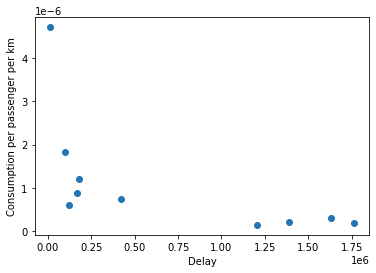

In [379]:
plt.xlabel('Delay')
plt.ylabel('Consumption per passenger per km')
plt.scatter(average_totals['average_delay'], average_totals['average_consumption'])
plt.show()

In [ ]:
#it does not seem to be true that higher average delays lead to more fuel consumption